In [ ]:
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np

CFG-Parameters in the [net] section:

[net] section
batch=1 - number of samples (images, letters, ...) which will be precossed in one batch

subdivisions=1 - number of mini_batches in one batch, size mini_batch = batch/subdivisions, so GPU processes mini_batch samples at once, and the weights will be updated for batch samples (1 iteration processes batch images)

width=416 - network size (width), so every image will be resized to the network size during Training and Detection

height=416 - network size (height), so every image will be resized to the network size during Training and Detection

channels=3 - network size (channels), so every image will be converted to this number of channels during Training and Detection

inputs=256 - network size (inputs) is used for non-image data: letters, prices, any custom data

max_chart_loss=20 - max value of Loss in the image chart.png

For training only

Contrastive loss:

contrastive=1 - use Supervised contrastive loss for training Classifier (should be used with [contrastive] layer)

unsupervised=1 - use Unsupervised contrastive loss for training Classifier on images without labels (should be used with contrastive=1 parameter and with [contrastive] layer)

Data augmentation:

angle=0 - randomly rotates images during training (classification only)

saturation = 1.5 - randomly changes saturation of images during training

exposure = 1.5 - randomly changes exposure (brightness) during training

hue=.1 - randomly changes hue (color) during training https://en.wikipedia.org/wiki/HSL_and_HSV

blur=1 - blur will be applied randomly in 50% of the time: if 1 - will be blured background except objects with blur_kernel=31, if >1 - will be blured whole image with blur_kernel=blur (only for detection and if OpenCV is used)

min_crop=224 - minimum size of randomly cropped image (classification only)

max_crop=448 - maximum size of randomly cropped image (classification only)

aspect=.75 - aspect ration can be changed during croping from 0.75 - to 1/0.75 (classification only)

letter_box=1 - keeps aspect ratio of loaded images during training (detection training only, but to use it during detection-inference - use flag -letter_box at the end of detection command)

cutmix=1 - use CutMix data augmentation (for Classifier only, not for Detector)

mosaic=1 - use Mosaic data augmentation (4 images in one)

mosaic_bound=1 - limits the size of objects when mosaic=1 is used (does not allow bounding boxes to leave the borders of their images when Mosaic-data-augmentation is used)

data augmentation in the last [yolo]-layer

jitter=0.3 - randomly changes size of image and its aspect ratio from x(1 - 2*jitter) to x(1 + 2*jitter)
random=1 - randomly resizes network size after each 10 batches (iterations) from /1.4 to x1.4 with keeping initial aspect ratio of network size
adversarial_lr=1.0 - Changes all detected objects to make it unlike themselves from neural network point of view. The neural network do an adversarial attack on itself

attention=1 - shows points of attention during training

gaussian_noise=1 - add gaussian noise

Optimizator:

momentum=0.9 - accumulation of movement, how much the history affects the further change of weights (optimizer)

decay=0.0005 - a weaker updating of the weights for typical features, it eliminates dysbalance in dataset (optimizer) http://cs231n.github.io/neural-networks-3/

learning_rate=0.001 - initial learning rate for training

burn_in=1000 - initial burn_in will be processed for the first 1000 iterations, current_learning rate = learning_rate * pow(iterations / burn_in, power) = 0.001 * pow(iterations/1000, 4) where is power=4 by default

max_batches = 500200 - the training will be processed for this number of iterations (batches)

policy=steps - policy for changing learning rate: constant (by default), sgdr, steps, step, sig, exp, poly, random (f.e., if policy=random - then current learning rate will be changed in this way = learning_rate * pow(rand_uniform(0,1), power))

power=4 - if policy=poly - the learning rate will be = learning_rate * pow(1 - current_iteration / max_batches, power)

sgdr_cycle=1000 - if policy=sgdr - the initial number of iterations in cosine-cycle

sgdr_mult=2 - if policy=sgdr - multiplier for cosine-cycle https://towardsdatascience.com/https-medium-com-reina-wang-tw-stochastic-gradient-descent-with-restarts-5f511975163

steps=8000,9000,12000 - if policy=steps - at these numbers of iterations the learning rate will be multiplied by scales factor

scales=.1,.1,.1 - if policy=steps - f.e. if steps=8000,9000,12000, scales=.1,.1,.1 and the current iteration number is 10000 then current_learning_rate = learning_rate * scales[0] * scales[1] = 0.001 * 0.1 * 0.1 = 0.00001

label_smooth_eps=0.1 - use label smoothing for training Classifier

For training Recurrent networks:

Object Detection/Tracking on Video - if [conv-lstm] or [crnn] layers are used in additional to [connected] and [convolutional] layers

Text generation - if [lstm] or [rnn] layers are used in additional to [connected] layers

track=1 - if is set 1 then the training will be performed in Recurrents-tyle for image sequences

time_steps=16 - training will be performed for a random image sequence that contains 16 images from train.txt file

for [convolutional]-layers: mini_batch = time_steps*batch/subdivisions
for [conv_lstm]-recurrent-layers: mini_batch = batch/subdivisions and sequence=16
augment_speed=3 - if set 3 then can be used each 1st, 2nd or 3rd image randomly, i.e. can be used 16 images with indexes 0, 1, 2, ... 15 or 110, 113, 116, ... 155 from train.txt file

sequential_subdivisions=8 - lower value increases the sequence of images, so if time_steps=16 batch=16 sequential_subdivisions=8, then will be loaded time_steps*batch/sequential_subdivisions = 16*16/8 = 32 sequential images with the same data-augmentation, so the model will be trained for sequence of 32 video-frames

seq_scales=0.5, 0.5 - increasing sequence of images at some steps, i.e. the coefficients to which the original sequential_subdivisions value will be multiplied (and batch will be dividied, so the weights will be updated rarely) at correspond steps if is used policy=steps or policy=sgdr

CFG-Parameters in the different layers
Image processing [N x C x H x W]:

[convolutional] - convolutional layer

batch_normalize=1 - if 1 - will be used batch-normalization, if 0 will not (0 by default)

filters=64 - number of kernel-filters (1 by default)

size=3 - kernel_size of filter (1 by default)

groups = 32 - number of groups for grouped-convolutional (depth-wise) (1 by default)

stride=1 - stride (offset step) of kernel filter (1 by default)

padding=1 - size of padding (0 by default)

pad=1 - if 1 will be used padding = size/2, if 0 the will be used parameter padding= (0 by default)

dilation=1 - size of dilation (1 by default)

activation=leaky - activation function after convolution: logistic (by default), loggy, relu, elu, selu, relie, plse, hardtan, lhtan, linear, ramp, leaky, tanh, stair, relu6, swish, mish

[activation] - separate activation layer

activation=leaky - activation function: linear (by default), loggy, relu, elu, selu, relie, plse, hardtan, lhtan, linear, ramp, leaky, tanh, stair
[batchnorm] - separate Batch-normalization layer
[maxpool] - max-pooling layer (the maximum value)

size=2 - size of max-pooling kernel

stride=2 - stirde (offset step) of max-pooling kernel

[avgpool] - average pooling layer input W x H x C -> output 1 x 1 x C
[shortcut] - residual connection (ResNet)

from=-3,-5 - relative layer numbers, preforms element-wise adding of several layers: previous-layer and layers specified in from= parameter

weights_type=per_feature - will be used weights for shortcut y[i] = w1*layer1[i] + w2*layer2[i] ...

per_feature - 1 weights per layer/feature
per_channel - 1 weights per channel
none - weights will not be used (by default)
weights_normalization=softmax - will be used weights normalization

softmax - softmax normalization
relu - relu normalization
none - without weights normalization - unbound weights (by default)
activation=linear - activation function after shortcut/residual connection (linear by default)

[upsample] - upsample layer (increase W x H resolution of input by duplicating elements)

stride=2 - factor for increasing both Width and Height (new_w = w*stride, new_h = h*stride)
[scale_channels] - scales channels (SE: squeeze-and-excitation blocks) or (ASFF: adaptively spatial feature fusion) -it multiplies elements of one layer by elements of another layer

from=-3 - relative layer number, performs multiplication of all elements of channel N from layer -3, by one element of channel N from the previous layer -1 (i.e. for(int i=0; i < b*c*h*w; ++i) output[i] = from_layer[i] * previous_layer[i/(w*h)]; )

scale_wh=0 - SE-layer (previous layer 1x1xC), scale_wh=1 - ASFF-layer (previous layer WxHx1)

activation=linear - activation function after scale_channels-layer (linear by default)

[sam] - Spatial Attention Module (SAM) - it multiplies elements of one layer by elements of another layer

from=-3 - relative layer number (this and previous layers should be the same size WxHxC)
[reorg3d] - reorg layer (resize W x H x C)

stride=2 - if reverse=0 input will be resized to W/2 x H/2 x C4, if reverse=1thenW2 x H*2 x C/4`, (1 by default)

reverse=1 - if 0(by default) then decrease WxH, if1thenincrease WxH (0 by default)

[reorg] - OLD reorg layer from Yolo v2 - has incorrect logic (resize W x H x C) - depracated

stride=2 - if reverse=0 input will be resized to W/2 x H/2 x C4, if reverse=1thenW2 x H*2 x C/4`, (1 by default)

reverse=1 - if 0(by default) then decrease WxH, if1thenincrease WxH (0 by default)

[route] - concatenation layer, Concat for several input-layers, or Identity for one input-layer

layers = -1, 61 - layers that will be concatenated, output: W x H x C_layer_1 + C_layer_2
if index < 0, then it is relative layer number (-1 means previous layer)
if index >= 0, then it is absolute layer number
[yolo] - detection layer for Yolo v3 / v4

mask = 3,4,5 - indexes of anchors which are used in this [yolo]-layer

anchors = 10,13, 16,30, 33,23, 30,61, 62,45, 59,119, 116,90, 156,198, 373,326 - initial sizes if bounded_boxes that will be adjusted

num=9 - total number of anchors

classes=80 - number of classes of objects which can be detected

ignore_thresh = .7 - keeps duplicated detections if IoU(detect, truth) > ignore_thresh, which will be fused during NMS (is used for training only)

truth_thresh = 1 - adjusts duplicated detections if IoU(detect, truth) > truth_thresh, which will be fused during NMS (is used for training only)

jitter=.3 - randomly crops and resizes images with changing aspect ratio from x(1 - 2*jitter) to x(1 + 2*jitter) (data augmentation parameter is used only from the last layer)

random=1 - randomly resizes network for each 10 iterations from 1/1.4 to 1.4(data augmentation parameter is used only from the last layer)

resize=1.5 - randomly resizes image in range: 1/1.5 - 1.5x

max=200 - maximum number of objects per image during training

counters_per_class=100,10,1000 - number of objects per class in Training dataset to eliminate the imbalance

label_smooth_eps=0.1 - label smoothing

scale_x_y=1.05 - eliminate grid sensitivity

iou_thresh=0.2 - use many anchors per object if IoU(Obj, Anchor) > 0.2

iou_loss=mse - IoU-loss: mse, giou, diou, ciou

iou_normalizer=0.07 - normalizer for delta-IoU

cls_normalizer=1.0 - normalizer for delta-Objectness

max_delta=5 - limits delta for each entry

[crnn] - convolutional RNN-layer (recurrent)

batch_normalize=1 - if 1 - will be used batch-normalization, if 0 will not (0 by default)

size=1 - convolutional kernel_size of filter (1 by default)

pad=0 - if 1 will be used padding = size/2, if 0 the will be used parameter padding= (0 by default)

output = 1024 - number of kernel-filters in one output convolutional layer (1 by default)

hidden=1024 - number of kernel-filters in two (input and hidden) convolutional layers (1 by default)

activation=leaky - activation function for each of 3 convolutional-layers in the [crnn]-layer (logistic by default)

[conv_lstm] - convolutional LSTM-layer (recurrent)

batch_normalize=1 - if 1 - will be used batch-normalization, if 0 will not (0 by default)

size=3 - convolutional kernel_size of filter (1 by default)

padding=1 - convolutional size of padding (0 by default)

pad=1 - if 1 will be used padding = size/2, if 0 the will be used parameter padding= (by default)

stride=1 - convolutional stride (offset step) of kernel filter (1 by default)

dilation=1 - convolutional size of dilation (1 by default)

output=256 - number of kernel-filters in each of 8 or 11 convolutional layers (1 by default)

groups=4 - number of groups for grouped-convolutional (depth-wise) (1 by default)

state_constrain=512 - constrains LSTM-state values [-512; +512] after each inference (time_steps*32 by default)

peephole=0 - if 1 then will be used Peephole (additional 3 conv-layers), if 0 will not (1 by default)

bottleneck=0 - if 1 then will be used reduced optimal versionn of conv-lstm layer

activation=leaky - activation function for each of 8 or 11 convolutional-layers in the [conv_lstm]-layer (linear by default)

lstm_activation=tanh - activation for G (gate: g = tanh(wg + ug)) and C (memory cell: h = o * tanh(c))

Detailed-architecture-of-the-peephole-LSTM

Free-form data processing [Inputs]:

[connected] - fully connected layer
output=256 - number of outputs (1 by default), so number of connections is equal to inputs*outputs
activation=leaky - activation after layer (logistic by default)
[dropout] - dropout layer
probability=0.5 - dropout probability - what part of inputs will be zeroed (0.5 = 50% by default)

dropblock=1 - use as DropBlock

dropblock_size_abs=7 - size of DropBlock in pixels 7x7

[softmax] - SoftMax CE (cross entropy) layer - Categorical cross-entropy for multi-class classification
[contrastive] - Contrastive loss layer for Supervised and Unsupervised learning (should be set [net] contrastive=1 and optionally [net] unsupervised=1)

classes=1000 - number of classes

temperature=1.0 - temperature

[cost] - cost layer calculates (linear)Delta and (squared)Loss
type=sse - cost type: sse (L2), masked, smooth (smooth-L1) (SSE by default)
[rnn] - fully connected RNN-layer (recurrent)
batch_normalize=1 - if 1 - will be used batch-normalization, if 0 will not (0 by default)
output = 1024 - number of outputs in one connected layer (1 by default)
hidden=1024 - number of outputs in two (input and hidden) connected layers (1 by default)
activation=leaky - activation after layer (logistic by default)
[lstm] - fully connected LSTM-layer (recurrent)
batch_normalize=1 - if 1 - will be used batch-normalization, if 0 will not (0 by default)
output = 1024 - number of outputs in all connected layers (1 by default)
[gru] - fully connected GRU-layer (recurrent)
batch_normalize=1 - if 1 - will be used batch-normalization, if 0 will not (0 by default)
output = 1024 - number of outputs in all 

connected layers (1 by default)

Next, we need to normalize, scale and reshape this image to be suitable as an input to the neural network:

In [ ]:
import time

Now let's feed this image into the neural network to get the output predictions:

In [ ]:
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
# sets the blob as the input of the network
net.setInput(blob)
# get all the layer names
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
# feed forward (inference) and get the network output
# measure how much it took in seconds
layer_outputs = net.forward(ln)

getLayerNames(): Get the name of all layers of the network.

getUnconnectedOutLayers(): Get the index of the output layers.

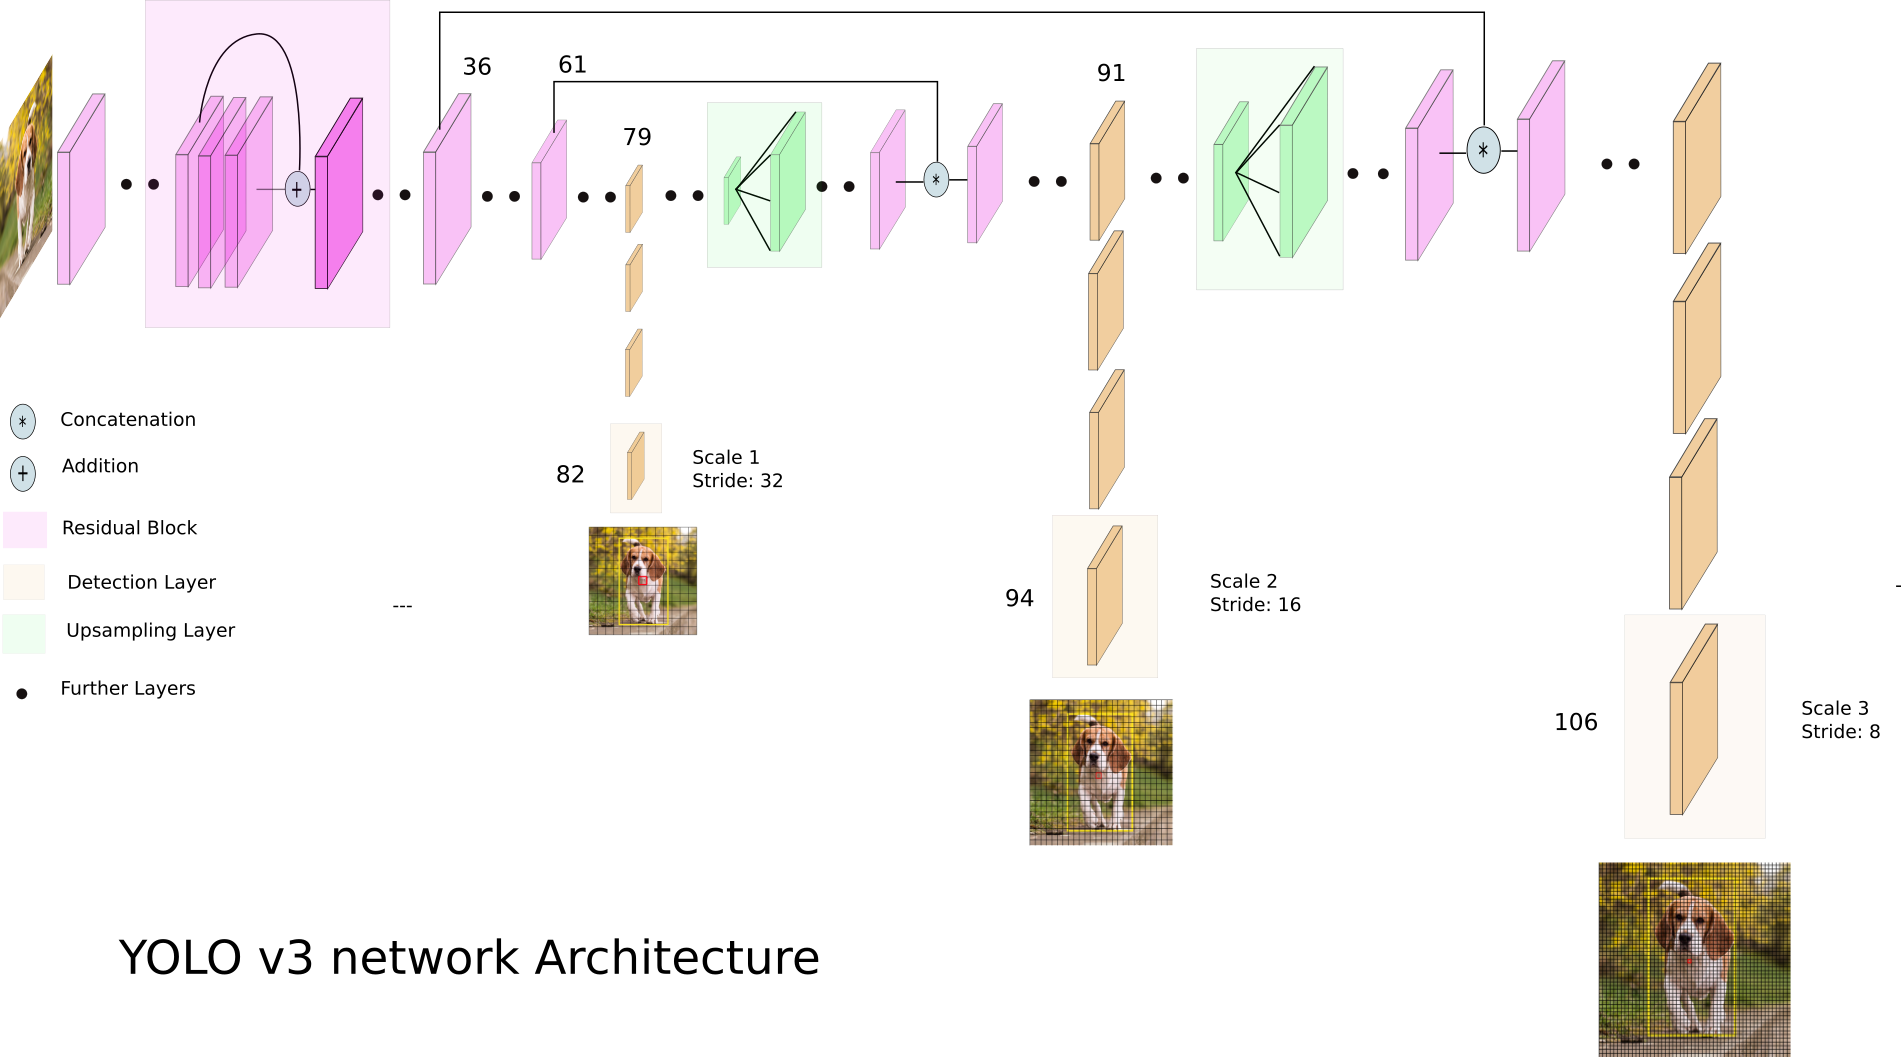

In above architecture if we run getUnconnectedOutLayers() then we get output of index 82,84,106

In [ ]:
net.getUnconnectedOutLayers()# at this case we get output at index of layers 200,227 and 254

array([[200],
       [227],
       [254]], dtype=int32)

In [ ]:
boxes = []
confidences = []
classIDs = []
for output in layer_outputs:
    for detection in output:
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]
        if confidence > 0.6  and classID==0:
            box = detection[:4]*np.array([w,h,w,h])
            (centerX, centerY, width, height) = box.astype("int")
            x = int (centerX-(width/2))
            y = int(centerY - (height / 2))
            boxes.append([x, y, int (width), int (height)])
            confidences.append(float (confidence))
            classIDs.append(classID)

### for training and to get the trained weight from yolo network we start from this place:

In [ ]:
!ln -s /content/drive/My\ Drive/ /mydrive

ln: failed to create symbolic link '/mydrive/My Drive': Operation not supported



1) Clone, configure & compile Darknet

In [ ]:
#clone
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 14662 (delta 0), reused 1 (delta 0), pack-reused 14658
Receiving objects: 100% (14662/14662), 13.25 MiB | 25.60 MiB/s, done.
Resolving deltas: 100% (9979/9979), done.


In [ ]:
#configure
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
##compile
!make

/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:926:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1127:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
           

In [ ]:
!echo -e 'with_mask\nwithout_mask\nmask_weared_incorrect'> /content/darknet/data/obj.names

In [ ]:
!cp cfg/yolov3.cfg cfg/yolov3_training.cfg

In [ ]:

# Change lines in yolov3.cfg file
!sed -i 's/batch=1/batch=64/' cfg/yolov3_training.cfg
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov3_training.cfg
!sed -i 's/max_batches = 500200/max_batches = 6000/' cfg/yolov3_training.cfg
!sed -i '610 s@classes=80@classes=3@' cfg/yolov3_training.cfg
!sed -i '696 s@classes=80@classes=3@' cfg/yolov3_training.cfg
!sed -i '783 s@classes=80@classes=3@' cfg/yolov3_training.cfg
!sed -i '603 s@filters=255@filters=24@' cfg/yolov3_training.cfg
!sed -i '689 s@filters=255@filters=24@' cfg/yolov3_training.cfg
!sed -i '776 s@filters=255@filters=24@' cfg/yolov3_training.cfg

In [ ]:
!echo -e 'Wearing Mask\nwithout_mask\nmask_weared_incorrect' > data/obj.names
!echo -e 'classes= 3\ntrain  = data/train.txt\nvalid  = data/test.txt\nnames = data/obj.names\nbackup = /mydrive/yolov3' > data/obj.data

In [ ]:
!cp cfg/yolov3_training.cfg /mydrive/yolov3/yolov3_testing.cfg
!cp data/obj.names /mydrive/yolov3/classes.txt

In [ ]:
!rm -r /content/darknet/data/obj

In [ ]:
!mkdir data/obj

In [ ]:
!unzip /content/drive/MyDrive/yolov3/images.zip -d data/obj

Archive:  /content/drive/MyDrive/yolov3/images.zip
  inflating: data/obj/images1/maksssksksss0.png  
  inflating: data/obj/images1/maksssksksss0.txt  
  inflating: data/obj/images1/maksssksksss1.png  
  inflating: data/obj/images1/maksssksksss1.txt  
  inflating: data/obj/images1/maksssksksss10.png  
  inflating: data/obj/images1/maksssksksss10.txt  
  inflating: data/obj/images1/maksssksksss100.png  
  inflating: data/obj/images1/maksssksksss100.txt  
  inflating: data/obj/images1/maksssksksss101.png  
  inflating: data/obj/images1/maksssksksss101.txt  
  inflating: data/obj/images1/maksssksksss102.png  
  inflating: data/obj/images1/maksssksksss102.txt  
  inflating: data/obj/images1/maksssksksss103.png  
  inflating: data/obj/images1/maksssksksss103.txt  
  inflating: data/obj/images1/maksssksksss104.png  
  inflating: data/obj/images1/maksssksksss104.txt  
  inflating: data/obj/images1/maksssksksss105.png  
  inflating: data/obj/images1/maksssksksss105.txt  
  inflating: data/obj/i

In [ ]:
import glob
images_list = glob.glob("data/obj/images1/*.png")
with open("data/train.txt", "w") as f:
    f.write("\n".join(images_list))

In [ ]:
!./darknet detector train data/obj.data cfg/yolov3_training.cfg /content/drive/MyDrive/darknet53.conv.74 -dont_show

Streaming output truncated to the last 5000 lines.
 total_bbox = 152771, rewritten_bbox = 0.001964 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.701636), count: 5, class_loss = 1.193281, iou_loss = 0.549841, total_loss = 1.743121 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.575536), count: 2, class_loss = 0.604600, iou_loss = 0.304918, total_loss = 0.909518 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000453, iou_loss = 0.000000, total_loss = 0.000453 
 total_bbox = 152778, rewritten_bbox = 0.001964 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.576919), count: 4, class_loss = 0.592306, iou_loss = 0.572330, total_loss = 1.164636 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.602924), count: 6, class_loss = 1.478752, iou_loss = 0.973444, total_loss = 2.452196 
v3 (ms